In [1]:
# # link do colab: https://colab.research.google.com/drive/1gwOYmPriygEWK9kFpXLeKlvx3gqlSSNe#scrollTo=Ocurf4Uft6A_
# !pip install opencv-python-headless
# !pip install albumentations
# !pip install mediapipe
# !pip install rembg
# !pip install onnxruntime
# !pip install drive
# http://dl.yf.io/lsun/scenes/  

In [21]:
import kagglehub
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import random
import mediapipe as mp
from rembg import remove
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import pandas as pd

# Leitura de Conjuntos de Dados

In [372]:
## Conjunto de Background
## Link: https://www.kaggle.com/datasets/itsahmad/indoor-scenes-cvpr-2019 
backgrounds = kagglehub.dataset_download("itsahmad/indoor-scenes-cvpr-2019")


In [369]:
## Conjunto de dados de Libras e ASL
path_libras = "./standardized_datasets/LIBRAS_no_duplicates"
path_asl= "./standardized_datasets/ASL_no_duplicates"

In [370]:
print(os.listdir(path_asl))

['A', 'asl_alphabet_test', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'Synthetic ASL Alphabet', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [371]:
print(os.listdir(path_libras))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']


# Preparando paths para Data Augmentation
- Deixamos preparados já nos diretórios das letras "A", "B", "C" ...
- Para Backgrounds, já nos nomes dos backgrounds "airport_inside", "artstudio", ...

In [375]:
backgrounds = os.path.join(backgrounds, os.listdir(backgrounds)[0])
backgrounds = os.path.join(backgrounds, os.listdir(backgrounds)[0])
print(os.listdir(backgrounds))

['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']


In [181]:
# Verificando que número de pastas é 67, para ser utilizado posteriormente no código
# num_pastas = len([f for f in os.listdir(backgrounds) if os.path.isdir(os.path.join(backgrounds, f))])
# print(num_pastas)

67


# Configuração de Mediapipe Hands para Extração de Landmarks

In [184]:
## Medipipe Hands
mp_hands = mp.solutions.hands

## Se precisasse desenhar as mãos
# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles


# Função para adicionar Ruído Salt and Pepper


In [17]:
def noise_salt_and_pepper(salt_or_pepper, image):
  '''
      Função para adicionar ruído salt ou pepper
      "ou", pois pode-se adicionar um por vez, e se quiser adicionar ambos, é só chamar a função 2 vezes
      *salt_or_pepper
          Se salt_or_pepper = 255 (pixel branco), adiciona ruído salt
          Se salt_or_pepper = 0 (pixel preto), adiciona ruído pepper
      *image
          imagem a ser aplicada o ruído

  '''
  ## valor de ruído de 0 a 0.5%
  prob = np.random.uniform(0.0, 0.005)
  output = np.copy(image)
  ## prob * image_size calcula a quantidade de pixels que serão alterados
  ## np.ceil arrendonda para cima (necessita-se que o valor de pixels seja inteiro)
  p_alterados = int(prob * image.size)
  ## gera-se coordenadas únicas
  coords_x = np.random.randint(0, image.shape[1], p_alterados)
  coords_y = np.random.randint(0, image.shape[0], p_alterados)

  ## aplica-se o ruído
  output[coords_y, coords_x] = salt_or_pepper

  return output

# Definindo Save Paths
- Diretório onde dados serão salvos

In [302]:
## Definindo caminho para salvar os dados
save_path_libras = "./augmentadas/libras"
save_path_asl = "./augmentadas/asl"

## Criando caminhos
os.makedirs(save_path_libras, exist_ok=True)
os.makedirs(save_path_asl, exist_ok=True)



# Quantidade de Imagens por Diretório

In [351]:
def count_images_by_dir(path):
    """
    Conta a quantidade de imagens em cada subdiretório dentro do caminho fornecido.

    Parâmetros:
    -----------
    path : str
        Caminho para o diretório que contém subpastas com imagens organizadas por categorias.

    Retorno:
    --------
    pandas.DataFrame
        DataFrame com duas colunas: 'diretorio' (nome da subpasta) e 
        'quantidade_imagens' (número de arquivos de imagem encontrados).
    """
    dados = []
    for dir_ in os.listdir(path):
        dir_path = os.path.join(path, dir_)
        if os.path.isdir(dir_path):
            imagens = [
                f for f in os.listdir(dir_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')
            ]
            dados.append({'diretorio': dir_, 'quantidade_imagens': len(imagens)})
    
    return pd.DataFrame(dados)

In [ ]:
quant_images_asl = count_images_by_dir(path_asl)
quant_images_libras = count_images_by_dir(path_libras)

# Função para aplicar Data Augmentation

In [153]:
def aplica_data_aug(img_rgb, img_path, save_dir, transform, name, num_vezes):
    """
    Aplica Data Augmentation em 1 imagem, gerando "num_vezes" imagens.
    
    Parâmetros:
    -----------
    img_rgb : numpy.ndarray
        Imagem original no formato RGB, usada como base para aplicar as transformações.
    
    img_path : str
        Caminho da imagem original.
        
    save_dir : str
        Diretório onde as imagens aumentadas serão salvas.
    
    transform : callable
        Pipeline de transformações do Albumentations aplicada à imagem original.
    
    name : str
        Sufixo a ser adicionado ao nome das imagens geradas.
    
    num_vezes : int
        Número de vezes que as transformações e adições de ruído serão aplicadas. 
        Também é equivalente a quantas novas imagens serão geradas
    """

    base_name, ext = os.path.splitext(img_path)
    noise_options = {
        "both": [255, 0], 
        "salt": [255],
        "pepper": [0],
        "none": []
    }
    
    ## Gera várias imagens. No código usamos ela como geradora de 1 imagem por vez
    for i in range(num_vezes):
        ## Transforma a imagem com transformações tradicionais (rotação, hue, brightness, ...)
        augmented = transform(image=img_rgb)["image"]

        ## "noise_type" define se na imagem original será aplicada salt, pepper, ambos ou nenhum, de acordo com o dicionário "noise_options"
        noise_type = random.choice(list(noise_options))
        selected_noise = noise_options[noise_type]

        try:
            if noise_type == "none":
                augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
                aug_img_path = os.path.join(save_dir, f"{base_name}_{name}_{i}_none.jpg")
                success = cv2.imwrite(aug_img_path, augmented_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
                if not success:
                    print(f"[ERRO] Falha ao salvar imagem: {aug_img_path}")
            elif noise_type == "both":
                augmented_noisy = noise_salt_and_pepper(255, augmented) 
                augmented_noisy = noise_salt_and_pepper(0, augmented_noisy)
                augmented_bgr = cv2.cvtColor(augmented_noisy, cv2.COLOR_RGB2BGR)
                aug_img_path = os.path.join(save_dir, f"{base_name}_{name}_{i}_both.jpg")
                success = cv2.imwrite(aug_img_path, augmented_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
                if not success:
                    print(f"[ERRO] Falha ao salvar imagem: {aug_img_path}")
            else:
                for noise_value in selected_noise:
                    augmented_noisy = noise_salt_and_pepper(noise_value, augmented)
                    augmented_bgr = cv2.cvtColor(augmented_noisy, cv2.COLOR_RGB2BGR)
                    aug_img_path = os.path.join(save_dir, f"{base_name}_{name}_{i}_{noise_value}.jpg")
                    success = cv2.imwrite(aug_img_path, augmented_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
                    if not success:
                        print(f"[ERRO] Falha ao salvar imagem: {aug_img_path}")
        except Exception as e:
            print(f"[EXCEPTION] Erro ao salvar imagem {aug_img_path}: {e}")


In [308]:
def data_aug(path, save_path, quant_images, df_quant_images, max_images):
    """
    Aplica data augmentation tradicional (sem mudança de background)
    em um conjunto de imagens organizadas por diretórios. Usa "aplica_data_aug" iterativamente.
    
    A função percorre os diretórios de classes dentro do caminho base, calcula quantas imagens precisam ser geradas
    para atingir o total definido por `max_images` e aplica uma série de transformações visuais usando a biblioteca Albumentations.
    As novas imagens são salvas no diretório de destino correspondente.
    
    Parâmetros:
    -----------
    path : str
        Caminho para o diretório raiz contendo subpastas com imagens por classe.
    
    save_path : str
        Caminho onde as imagens aumentadas serão salvas, organizadas por subpastas de classe.
    
    quant_images : int
        Quantidade de imagens aumentadas a serem geradas por imagem original selecionada.
    
    df_quant_images : pandas.DataFrame
        DataFrame com duas colunas: 'diretorio' e 'quantidade_imagens', informando quantas imagens originais cada pasta já possui.
    
    max_images : int
        Número máximo desejado de imagens por diretório/classe (considerando-se originais + augmentadas) após a aplicação do data augmentation.
        Libras: 1200
        ASL: 5000
    """
  ## Definindo instância de Transformações utilizando-se albumentations
  transform = A.Compose([
          A.ColorJitter(brightness=0.4, contrast=0, saturation=0, hue=0, p=0.5),  ## Ajusta brilho
          A.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0, p=0.5),  ## Ajusta contraste
          A.ColorJitter(brightness=0, contrast=0, saturation=0.4, hue=0, p=0.5),  ## Ajusta cor
          A.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5, p=0.5),  ## Ajusta hue
          A.HorizontalFlip(p=0.5),  ## Flip horizontal
          A.Rotate(limit=10, p=0.5),  ## Rotação aleatória de ±10°
  ])
  for dir_ in os.listdir(path):
      ## Pegando-se caminho da pasta da letra. Por exemplo, letra "A"
      ## Código comentado: usar se não quiser percorrer por alguma pasta, ou se já tiver processado uma fração do df
      ##   if dir_ != "Blank" and (dir_ not in ["del", "asl_alphabet_test", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N","O", "P", "Q", "R", "S", "nothing"]):
          path_atual = os.path.join(path, dir_)
          save_dir = os.path.join(save_path, dir_)
          os.makedirs(save_dir, exist_ok=True)
    
          ## Pega todas as imagens do diretório atual, ignorando-se arquivos ocultos
          img_files = [
              f for f in os.listdir(path_atual)
              if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('.')
          ]
    
          if not img_files:
              print(f"Nenhuma imagem encontrada no diretório: {path_atual}")
              continue  ## Vai para próxima pasta se não houver imagem

          ## Gerando-se a quantidade de imagens a serem geradas ( foco no BALANCEAMENTO dos dados)
          quant_imagens_existentes = df_quant_images[df_quant_images['diretorio'] == dir_]['quantidade_imagens'].values[0]
          num_to_generate= int(max_images - quant_imagens_existentes)
        
          quant_geradas = 0
          i = 0
          max_i = len(img_files)
        
          while quant_geradas < num_to_generate:
              if i >= max_i:
                  i = 0
          
              ## Seleciona uma imagem a cada 4, com offset i
              selected_imgs = img_files[i::4]
              i += 1
        
              for img_path in selected_imgs:
                if quant_geradas >= num_to_generate:
                      break
        
                img_full_path = os.path.join(path, dir_, img_path)
                img = cv2.imread(img_full_path)
        
                if img is None:
                      print(f"Erro ao carregar imagem: {img_full_path}")
                      continue
                
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ## Aplica o Data Aug. Tradiconal
                aplica_data_aug(img_rgb, img_path, save_dir, transform, "aug_normal", quant_images)
                ## Aumenta a quantidade de imagens até que a quantidade de imagens geradas seja maior que a quantidade a se gerar
                quant_geradas += quant_images


In [312]:
## Por label:
## Imagens originais + Imagens augmentadas = 1200
data_aug(path_libras, save_path_libras, 1,quant_images_libras, 1200)

In [313]:
## Por label:
## Imagens originais + Imagens augmentadas = 1200
data_aug(path_asl, save_path_asl, 1,quant_images_asl, 5000)

space
T
U
V
W
X
Y
Z


In [343]:
def data_aug_background(path, save_path, backgrounds_path, num_to_generate):
    """
    Aplica Data Augmentation trocando o fundo das imagens por imagens de diferentes ambientes.
    
    A função percorre subpastas de classes dentro do diretório base, remove o fundo das imagens, substitui o fundo das imagens
    originais por fundos variados com auxílio do Mediapipe para detecção de mãos, e salva os resultados
    no diretório de destino. O fundo só é trocado se uma mão for detectada na imagem sem fundo, com confiança do Mediapipe de 70% (threshold)
    
    Parâmetros:
    -----------
    path : str
        Caminho para o diretório raiz contendo subpastas com imagens por classe (ex: letras do alfabeto em LIBRAS).
    
    save_path : str
        Caminho onde as imagens com fundo substituído serão salvas, organizadas por subpastas de classe.
    
    backgrounds_path : str
        Caminho para a pasta contendo subpastas com imagens de diferentes ambientes a serem usados como fundo.
    
    num_to_generate : int
        Número de imagens com fundo substituído a serem geradas por classe.
    """
  ## Defini instância de hands do mediapipe
  hands = mp_hands.Hands(static_image_mode = True, min_detection_confidence = 0.7)
  i_pasta = 0
  target_size = (224,224)
  ## Define os paths de background, para que eles possam ser resgatados mais otimizadamente no "for dir_"
  background_paths = {}
  for nome_ambiente in os.listdir(backgrounds_path):
        amb_path = os.path.join(backgrounds_path, nome_ambiente)
        if os.path.isdir(amb_path):
            imagens = [f for f in os.listdir(amb_path) if f.lower().endswith(('jpg', 'png', 'jpeg'))]
            if imagens:
               background_paths[nome_ambiente] = [os.path.join(amb_path, img) for img in imagens]
  ## Variável que define qual o ambiente atual (vai de 0 a 66)
  ambiente_index = 0
  ## Lista com todas as chaves de backgrounds
  ambientes_list = list(background_paths.keys())
  for dir_ in os.listdir(path):
      ## Código comentado: usar se não quiser percorrer por alguma pasta, ou se já tiver processado uma fração do df
      # if dir_ != "Blank" and (dir_ not in ["space","del", "Synthetic ASL Alphabet", "asl_alphabet_test", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N","O", "P", "Q", "R", "S", "nothing"]):          

          ## Pegando-se caminho da pasta da letra. Por exemplo, letra "A"
          path_atual = os.path.join(path, dir_)
          save_dir = os.path.join(save_path, dir_)
          os.makedirs(save_dir, exist_ok=True)
    
          ## Pega todas as imagens do diretório atual, ignorando-se arquivos ocultos
          img_files = [
              f for f in os.listdir(path_atual)
              if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('.')
          ]
    
          if not img_files:
              print(f"Nenhuma imagem encontrada no diretório: {path_atual}")
              continue  ## Vai para próxima pasta se não houver imagem
    
          quant_geradas = 0
          i = 0
          max_i = len(img_files)
          while quant_geradas < num_to_generate:
              ## Reinicia o índice se chegar ao fim da lista para permitir reutilização
              if i >= max_i:
                  i = 0
          
              ## Seleciona uma imagem a cada 4, com offset i
              selected_imgs = img_files[i::4]
              i += 1
        
              ## Percorre as imagens selecioandas para análise
              for img_path in selected_imgs:
                  if quant_geradas >= num_to_generate:
                      break
                      
                  ## Pega nome de ambiente
                  nome_ambiente = ambientes_list[ambiente_index]
    
                  ## Pega imagem aleatória do ambiente
                  image_fundo_path = random.choice(background_paths[nome_ambiente])
                  ambiente_index = (ambiente_index + 1) % len(ambientes_list) 
                  img_fundo = cv2.imread(image_fundo_path)
                  if img_fundo is None:
                      print(f"Erro ao carregar imagem: {img_fundo}")
                      continue
    
                  ## Pega-se path completo da imagem
                  img_full_path = os.path.join(path, dir_, img_path)
            
                  ## Lendo a imagem e verificando se há erro
                  img = cv2.imread(img_full_path)
                  if img is None:
                    print(f"Erro ao carregar imagem: {img_full_path}")
                    continue  ## Vai para próxima imagem se houver erro
                
                  # Convertendo-se de BGR (padrão de leitura CV2) para RGB
                  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
                  ## Convertendo-se a imagem de fundo para RGB
                  img_fundo = cv2.cvtColor(img_fundo, cv2.COLOR_BGR2RGB)
        
                  ## Convertendo-se imagem fundo para 224 x 224
                  ## Os filtros utilizados foram LANCZOS e BICUBIC
                  pil_img = Image.fromarray(img_fundo)
                  pil_img_resized = pil_img.resize(target_size, Image.LANCZOS if pil_img.width > target_size[0] or pil_img.height > target_size[1] else Image.BICUBIC)
                  img_fundo= np.array(pil_img_resized)
    
                  ## Removendo fundo de imagem
                  img_sem_bg  = remove(img_rgb) 
    
                  ## Mudando canais para ser adequado a Mediapipe
                  if img_sem_bg.shape[2] == 4:
                    img_sem_bg_2_channels = cv2.cvtColor(img_sem_bg, cv2.COLOR_BGRA2BGR)
                  else:
                    img_sem_bg_2_channels = img_sem_bg
    
                  results = hands.process(img_sem_bg_2_channels)
                  ## Se houver uma mão, então ele retira o fundo. Caso contrário, não retira
                  if results.multi_hand_landmarks is not None:
                      alpha = img_sem_bg[:, :, 3] / 255.0  
                      alpha = np.stack([alpha] * 3, axis=-1) 
                      img_bg_substituido = (img_sem_bg[:, :, :3] * alpha + img_fundo * (1 - alpha)).astype(np.uint8)
                   
                      image_bg_substituido = cv2.cvtColor(img_bg_substituido, cv2.COLOR_RGB2BGR)
                      ## Imagens sem fundo foram padronizadas por "0000000back" no início da imagem
                      aug_img_path = os.path.join(save_dir, f"0000000back_img_{nome_ambiente}_{quant_geradas}.jpg")
                      cv2.imwrite(aug_img_path, image_bg_substituido, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
                      quant_geradas+=1
                       

In [344]:
## Gera 200 imagens com background trocado por label
data_aug_background(path_libras, save_path_libras,backgrounds, 200)

In [348]:
## Gera 500 imagens com background trocado por label
data_aug_background(path_asl, save_path_asl,backgrounds, 500)

# Estatísticas antes e depois do Data Aug.

In [358]:
quant_images_asl['quantidade_imagens'].sum()

111851

In [359]:
quant_aug_asl['quantidade_imagens'].sum()

73677

In [360]:
df_soma_asl= pd.concat([quant_aug_asl, quant_images_asl]) \
            .groupby('diretorio', as_index=False)['quantidade_imagens'] \
            .sum()
df_soma_asl['quantidade_imagens'].sum()

185528

In [368]:
df_soma_asl

diretorio  quantidade_imagens
0                        A                5500
1                        B                5500
2                        C                5500
3                        D                5500
4                        E                5500
5                        F                5500
6                        G                5500
7                        H                5500
8                        I                5500
9                        J                5500
10                       K                5500
11                       L                5500
12                       M                5500
13                       N                5500
14                       O                5500
15                       P                5576
16                       Q                5500
17                       R                5500
18                       S                5500
19  Synthetic ASL Alphabet               27417
20                       T                5498
21                       U                5497
22                       V                5500
23                       W                5500
24                       X                5500
25                       Y                5500
26                       Z                5515
27       asl_alphabet_test                 530
28                     del                5493
29                 nothing                3493
30                   space                5509

In [361]:
quant_images_libras['quantidade_imagens'].sum()

12286

In [362]:
quant_aug_libras = count_images_by_dir(save_path_libras)
quant_aug_libras['quantidade_imagens'].sum()

16794

In [364]:
df_soma_libras = pd.concat([quant_aug_libras, quant_images_libras]) \
            .groupby('diretorio', as_index=False)['quantidade_imagens'] \
            .sum()
df_soma_libras['quantidade_imagens'].sum()

29080

In [367]:
df_soma_libras

diretorio  quantidade_imagens
0          A                1362
1          B                1369
2          C                1400
3          D                1375
4          E                1391
5          F                1397
6          G                1376
7          I                1392
8          L                1390
9          M                1400
10         N                1390
11         O                1400
12         P                1400
13         Q                1400
14         R                1359
15         S                1372
16         T                1400
17         U                1392
18         V                1372
19         W                1365
20         Y                1378

# Funções de Teste
- NÃO precisam ser implementadas na pipeline

In [ ]:
'''
  Função para aplicar Apagamento de Background em 1 imagem
  Semelhante à anterior, só que feita para apresentar imagens originais e sem fundo
  *path
      Caminho da pasta que contém imagens
'''
## Considere hands = mp_hands.Hands(static_image_mode = True, min_detection_confidence = 0.8)
def mudanca_fundo_img(img, hands):
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #fig, axes = plt.subplots(1, 2, figsize=(18, 6))
      img_sem_bg = remove(img)
      if img_sem_bg.shape[2] == 4:
          img_sem_bg = cv2.cvtColor(img_sem_bg, cv2.COLOR_BGRA2BGR)
      results = hands.process(img_sem_bg)
      if results.multi_hand_landmarks is not None:
            return img_sem_bg
      return None



In [63]:
'''
  Função para aplicar Apagamento de Background
  Semelhante à anterior, só que feita para apresentar imagens originais e sem fundo
  *path
      Caminho da pasta que contém imagens
'''
def mudanca_fundo_testes(path, confidence):
  hands = mp_hands.Hands(static_image_mode = True, min_detection_confidence = confidence)
  for dir_ in os.listdir(path):
      path_atual = os.path.join(path, dir_)
      img_files = [
          f for f in os.listdir(path_atual)
          if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('.')
      ]

      if not img_files:
          print(f"Nenhuma imagem encontrada no diretório: {path_atual}")
          continue

      img_path = random.choice(img_files)
      img_full_path = os.path.join(path, dir_, img_path)
      img = cv2.imread(img_full_path)

      if img is None:
          print(f"Erro ao carregar imagem: {img_full_path}")
          continue
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      fig, axes = plt.subplots(1, 2, figsize=(18, 6))

      img_sem_bg = remove(img)
      if img_sem_bg.shape[2] == 4:
          img_sem_bg = cv2.cvtColor(img_sem_bg, cv2.COLOR_BGRA2BGR)
      results = hands.process(img_rgb)
      if results.multi_hand_landmarks is not None:
        for hand_landmarks in results.multi_hand_landmarks:
            ## Desenha as landmarks
            mp_drawing.draw_landmarks(
                img_sem_bg,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

      ## Imagem Original
      axes[0].imshow(img_rgb)
      axes[0].axis("off")
      axes[0].set_title("Original")

      ## Imagem sem Fundo
      axes[1].imshow(img_sem_bg)
      axes[1].axis("off")
      axes[1].set_title("Sem Fundo")



<ipython-input-36-d5640e90b5aa>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(18, 6))


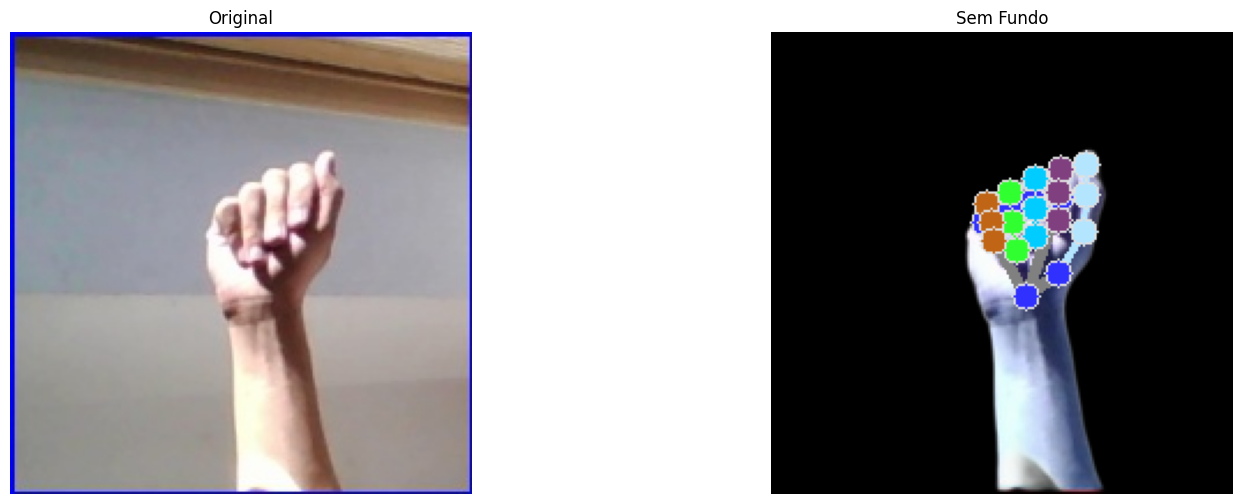

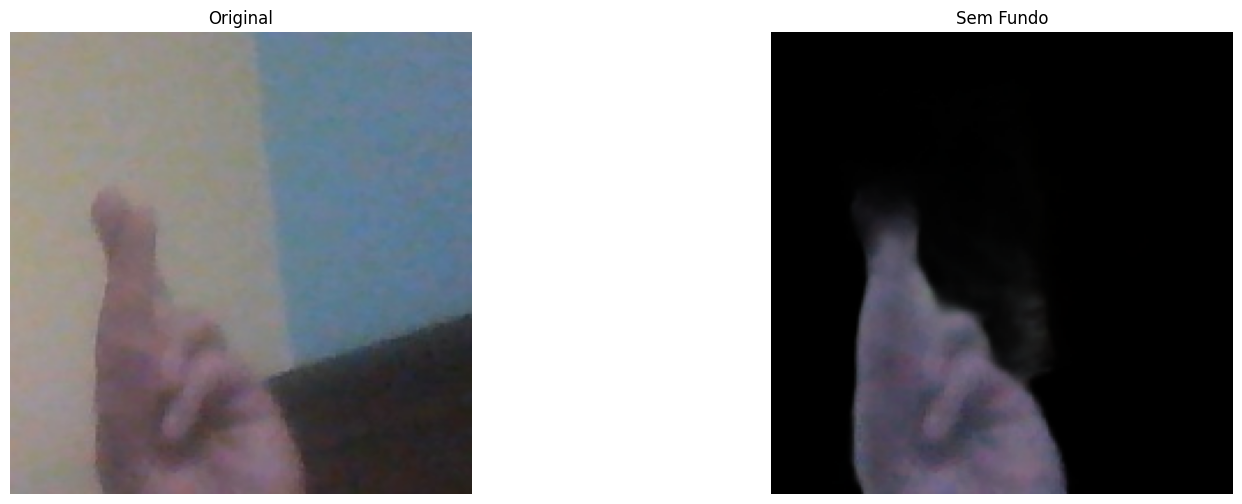

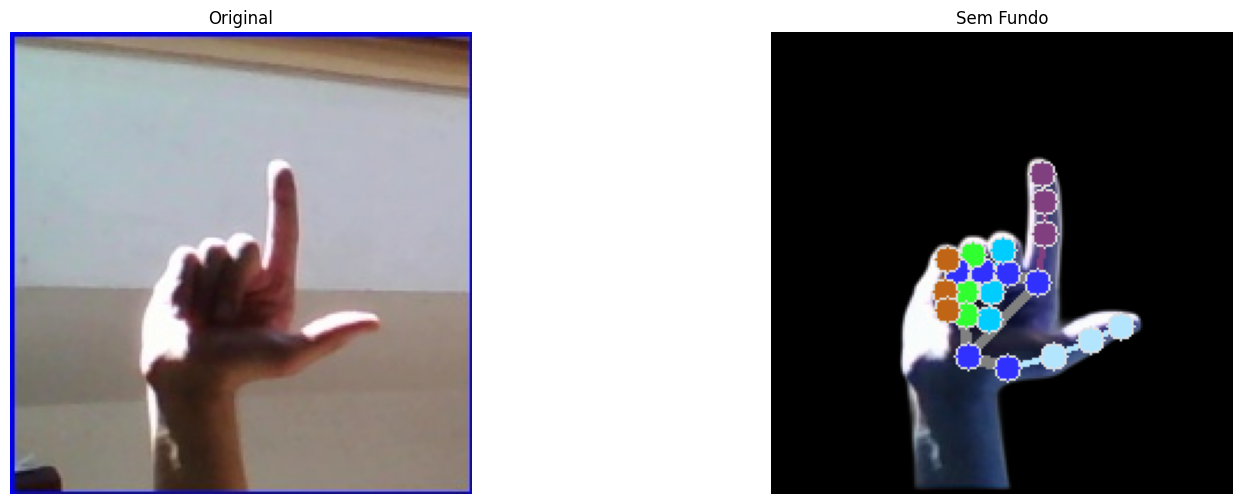

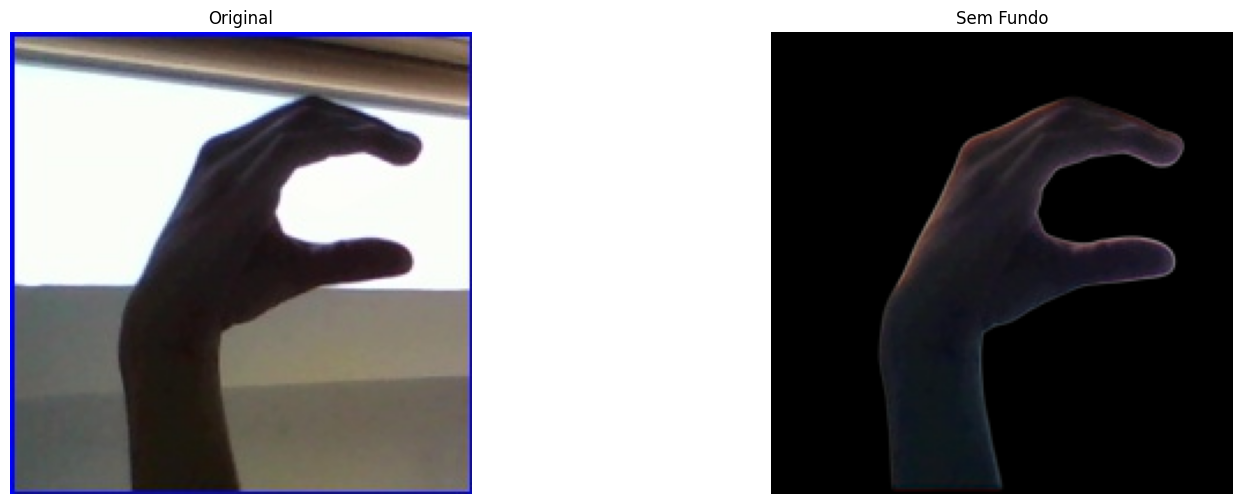

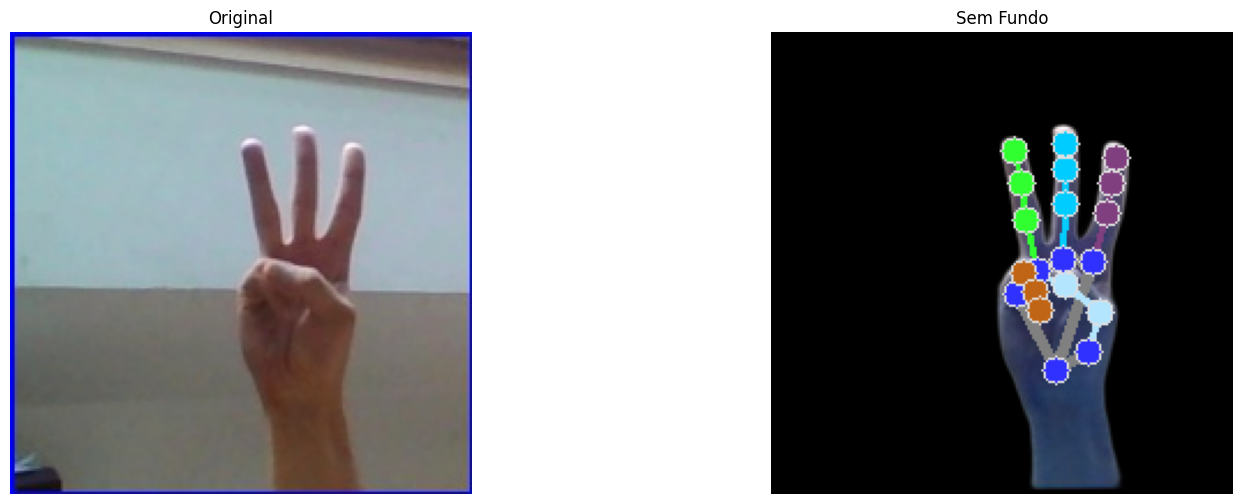

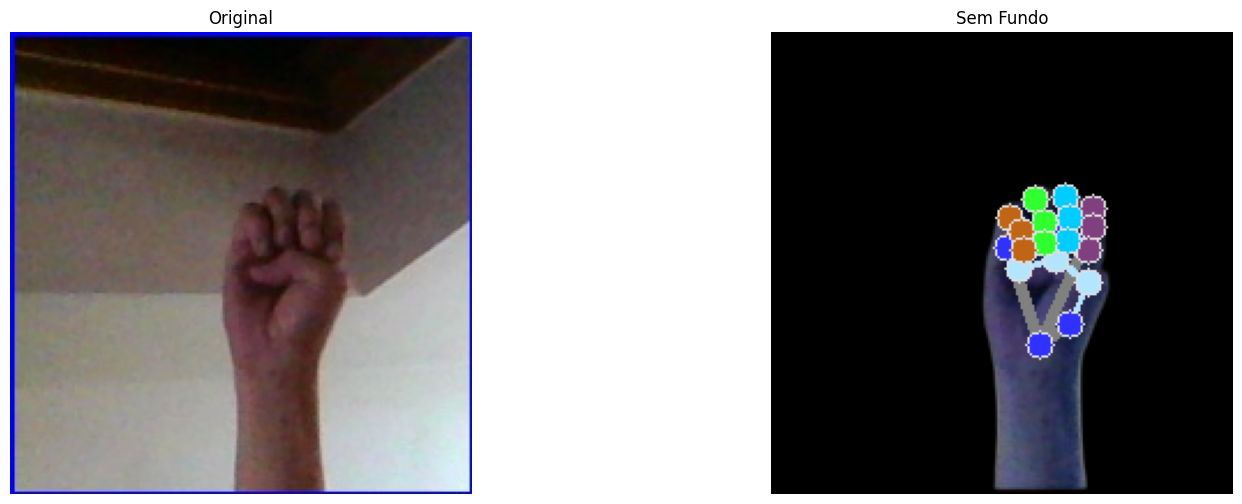

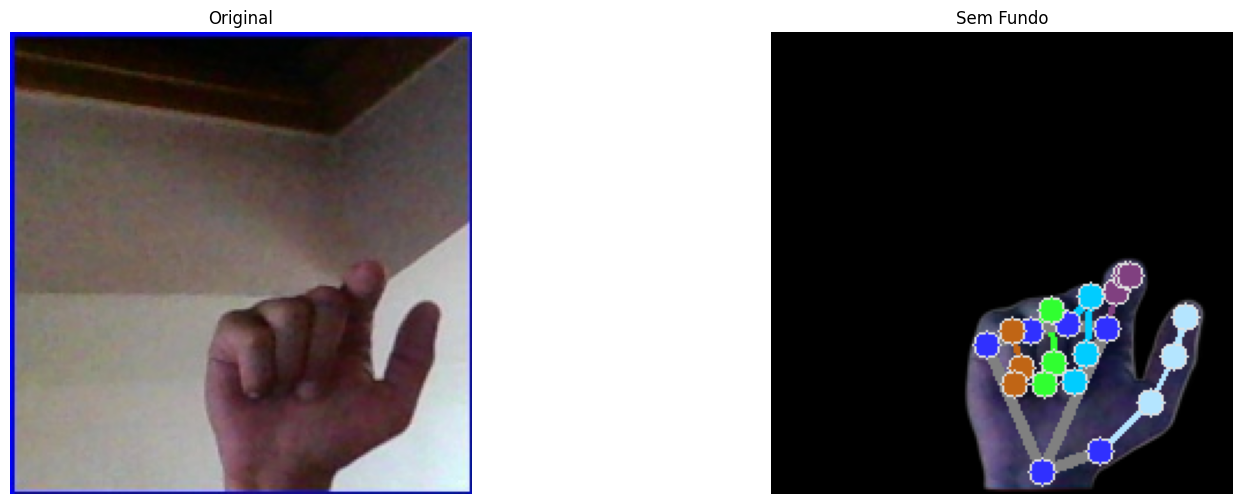

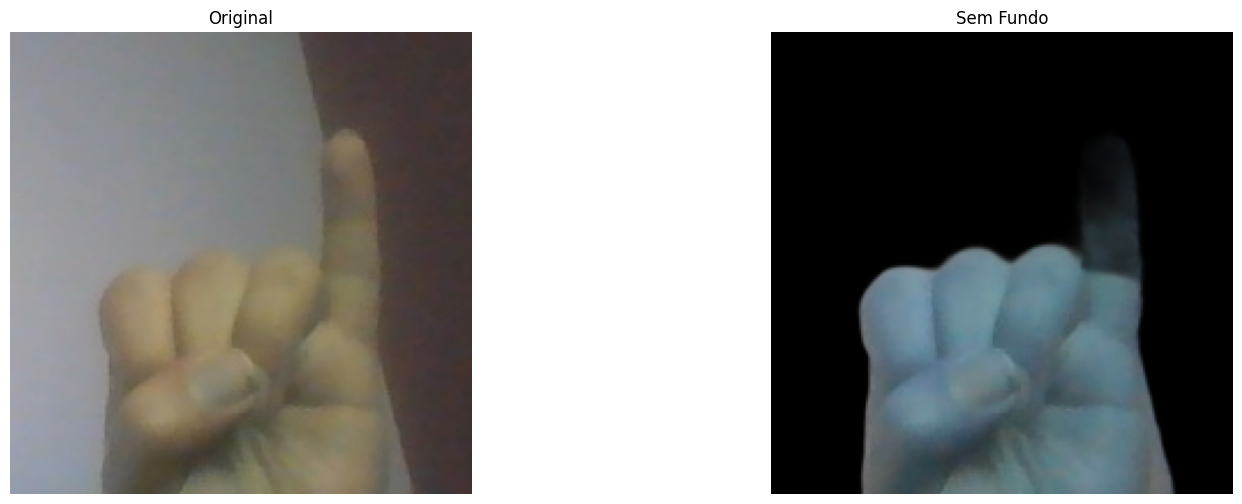

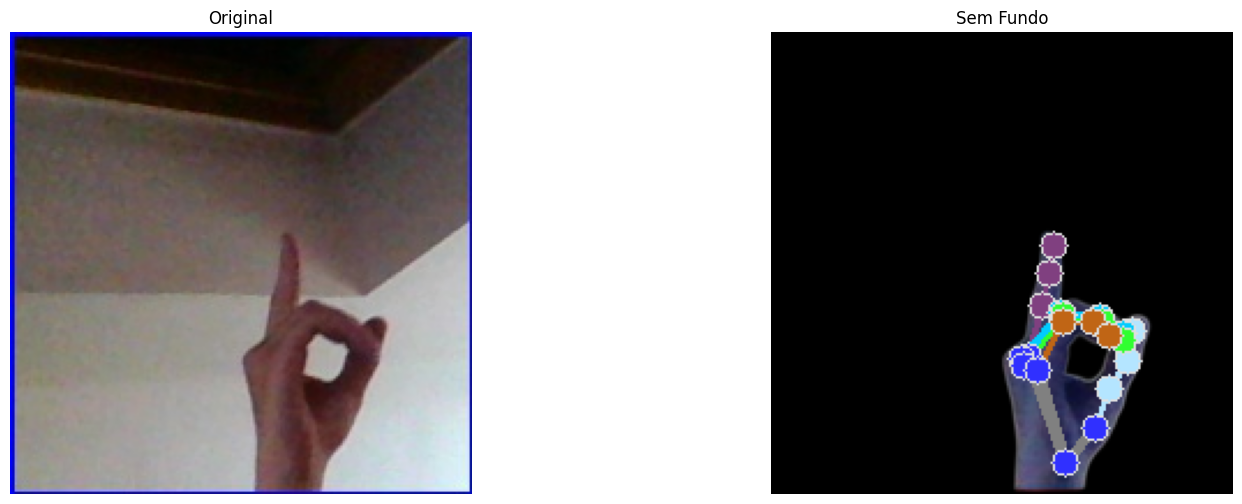

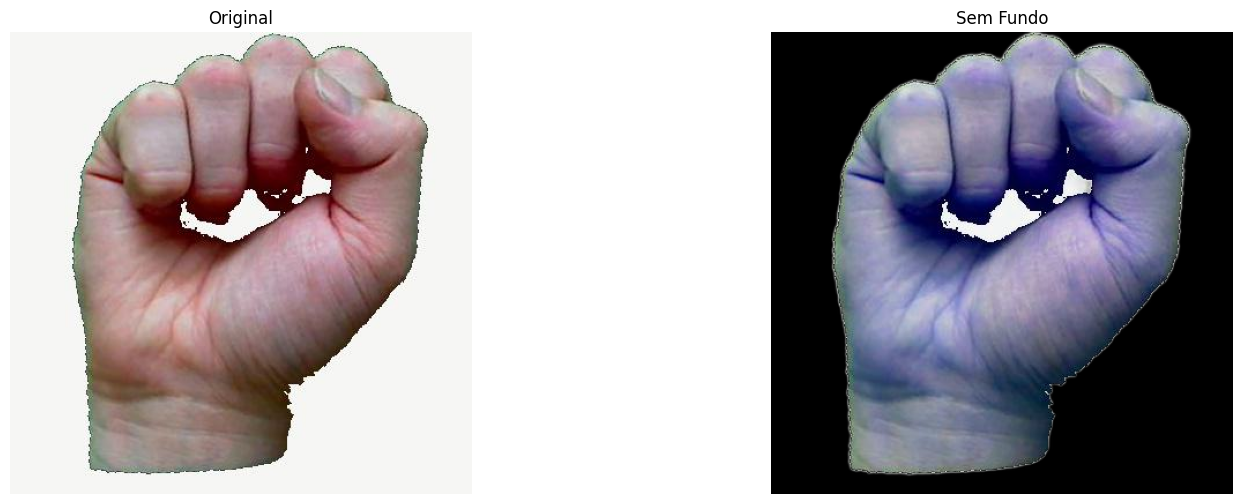

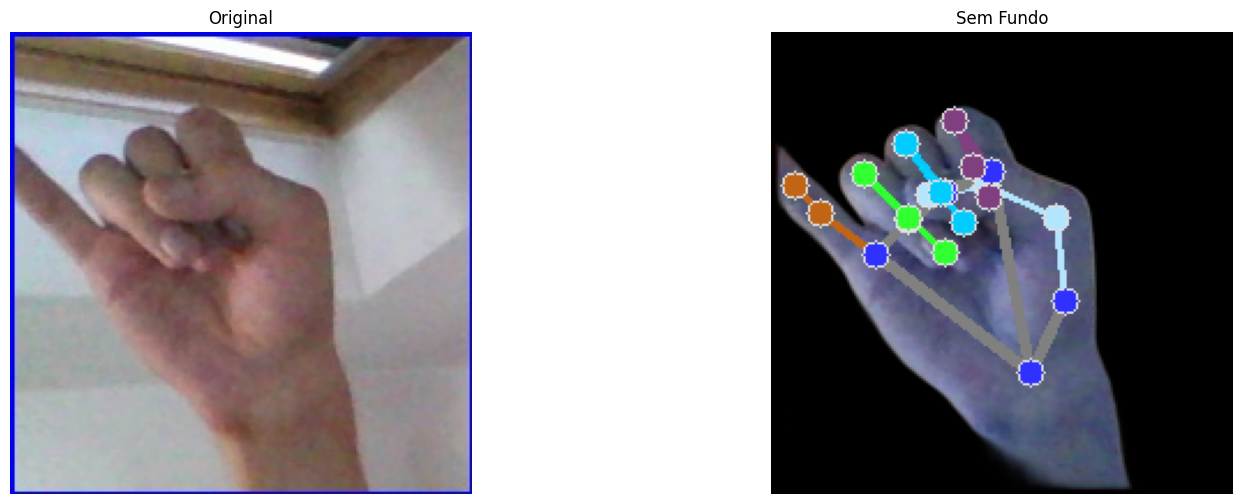

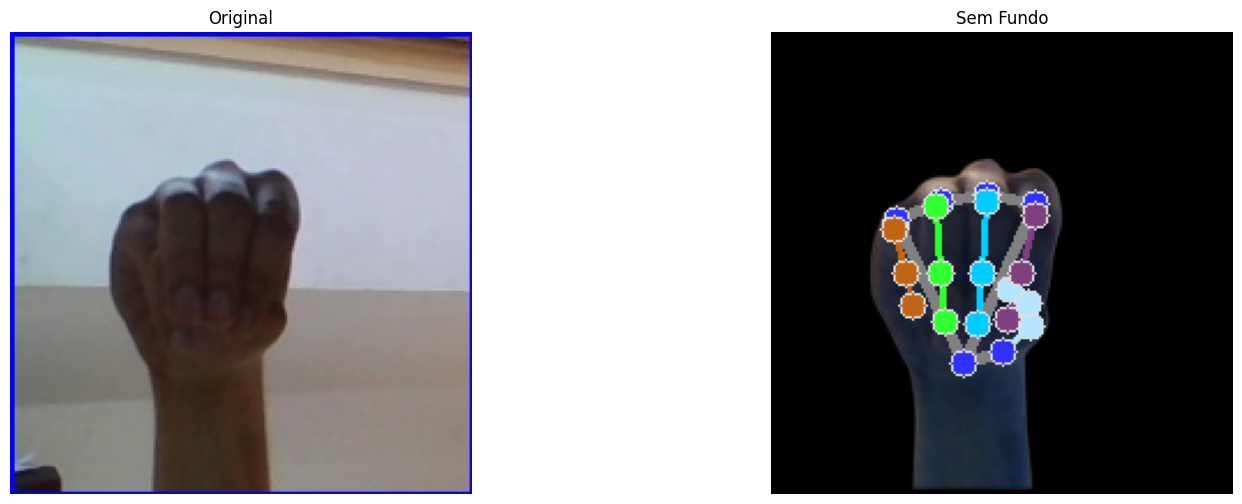

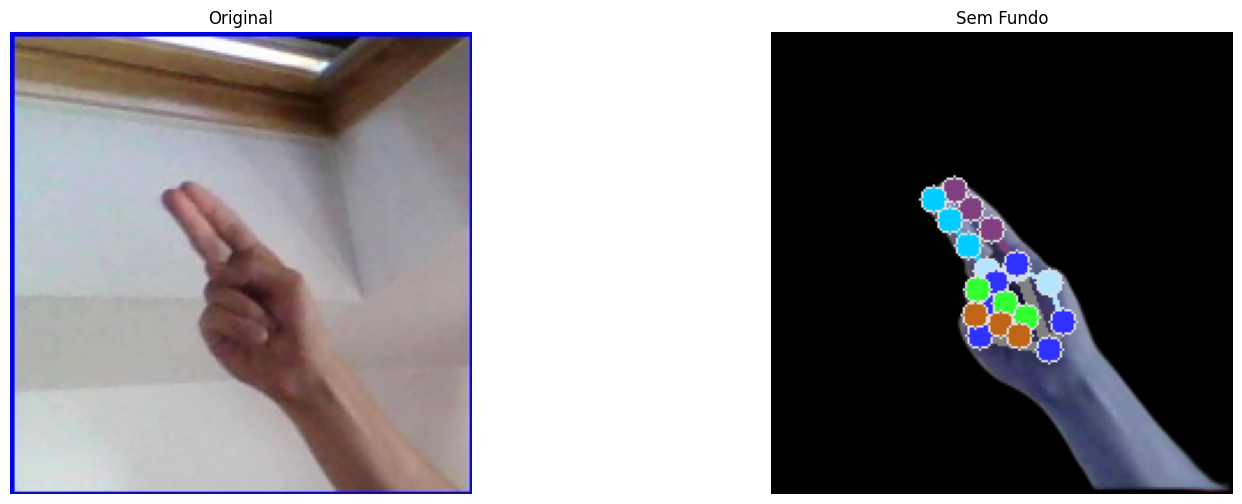

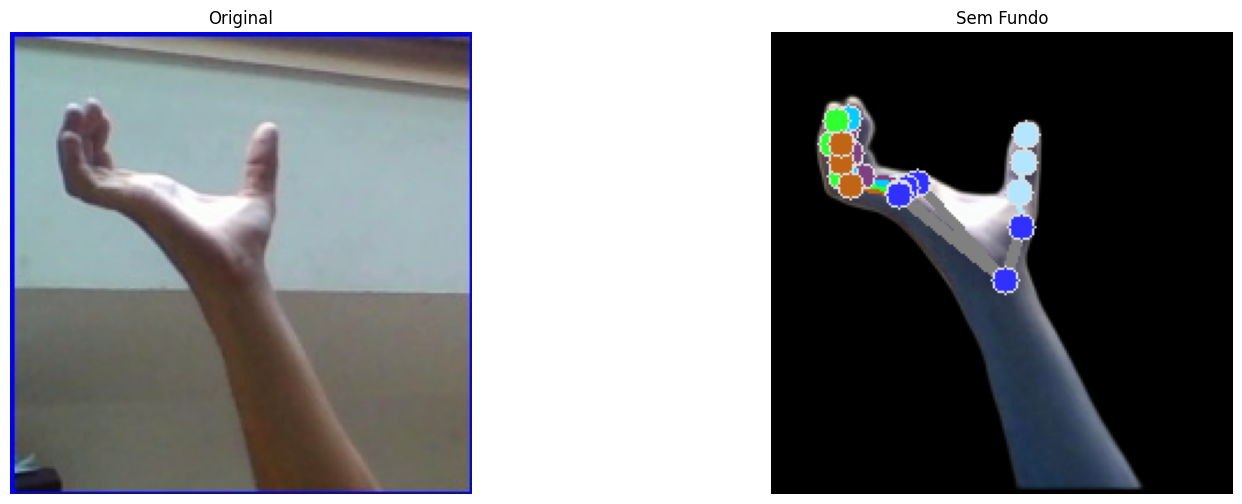

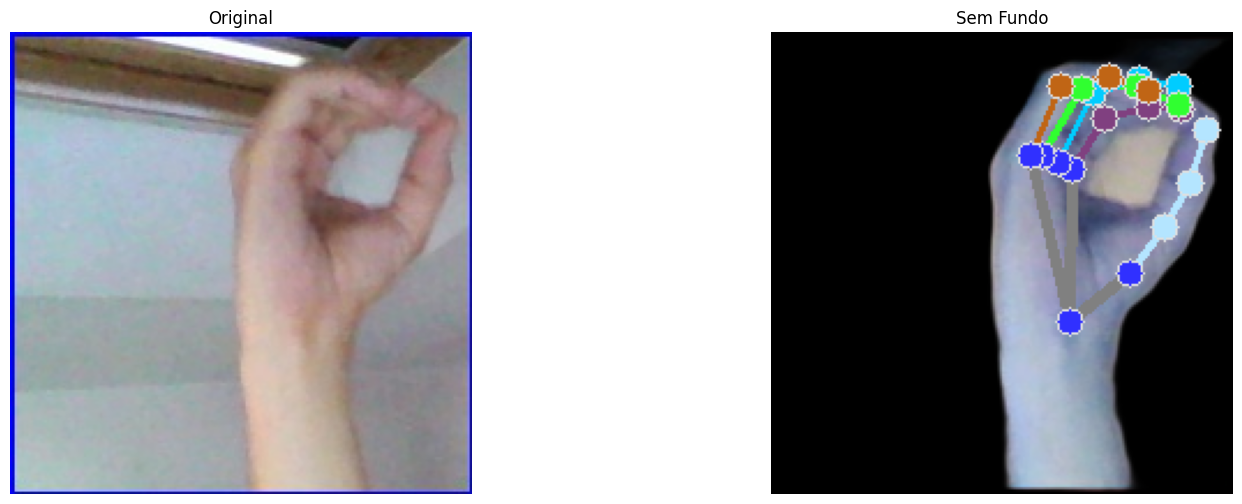

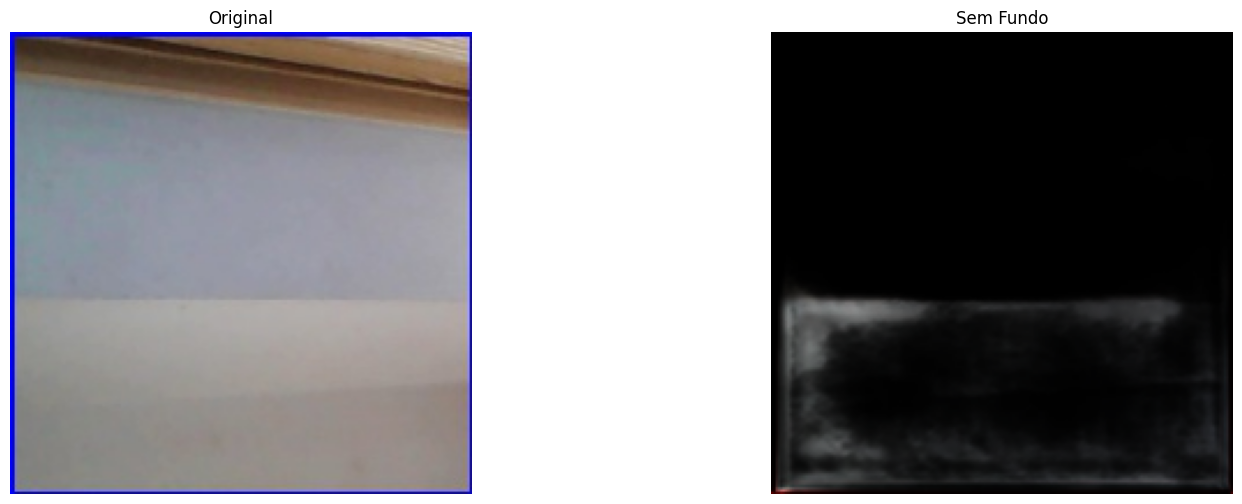

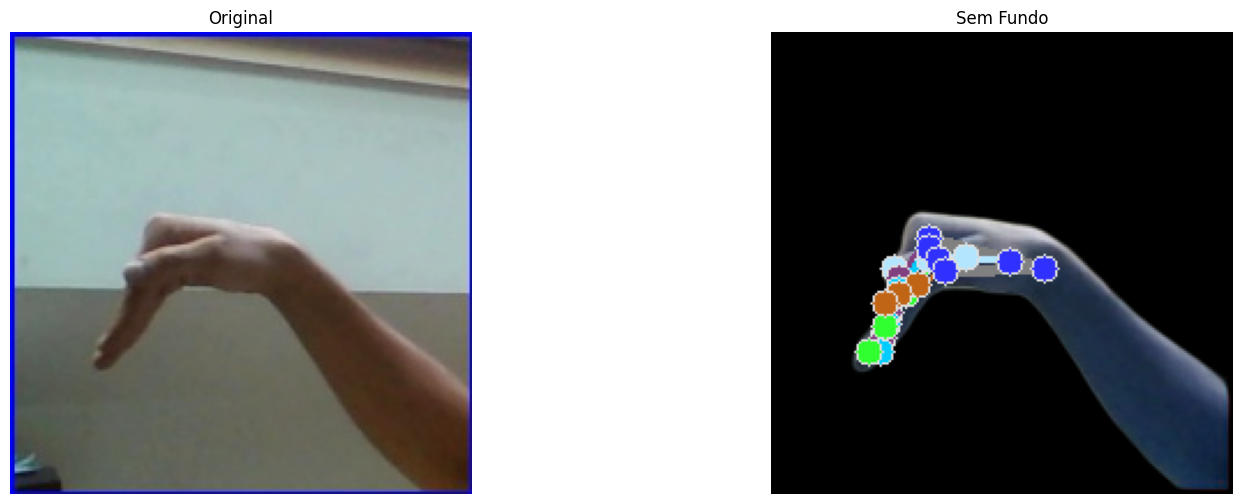

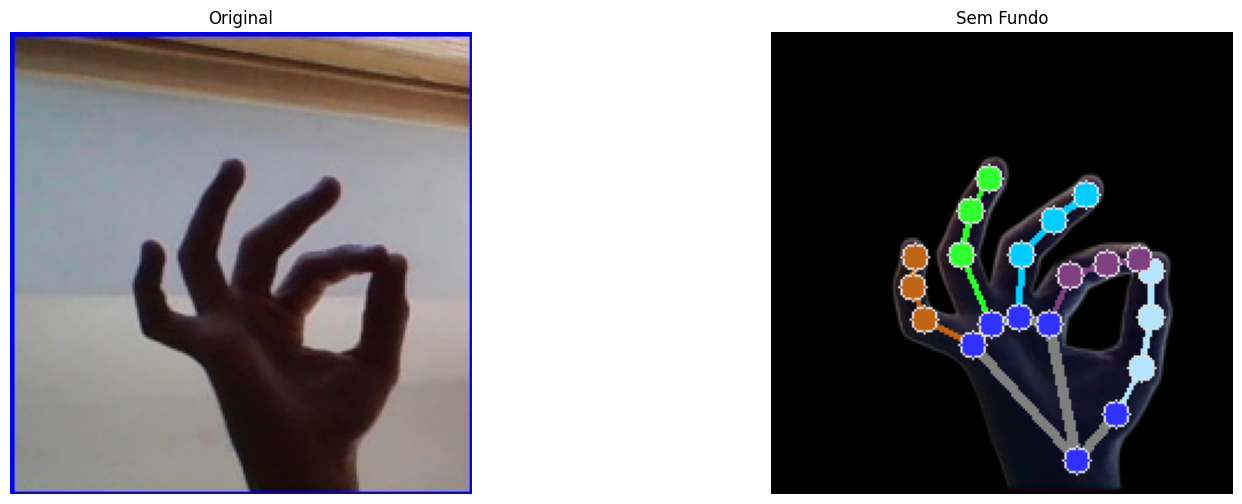

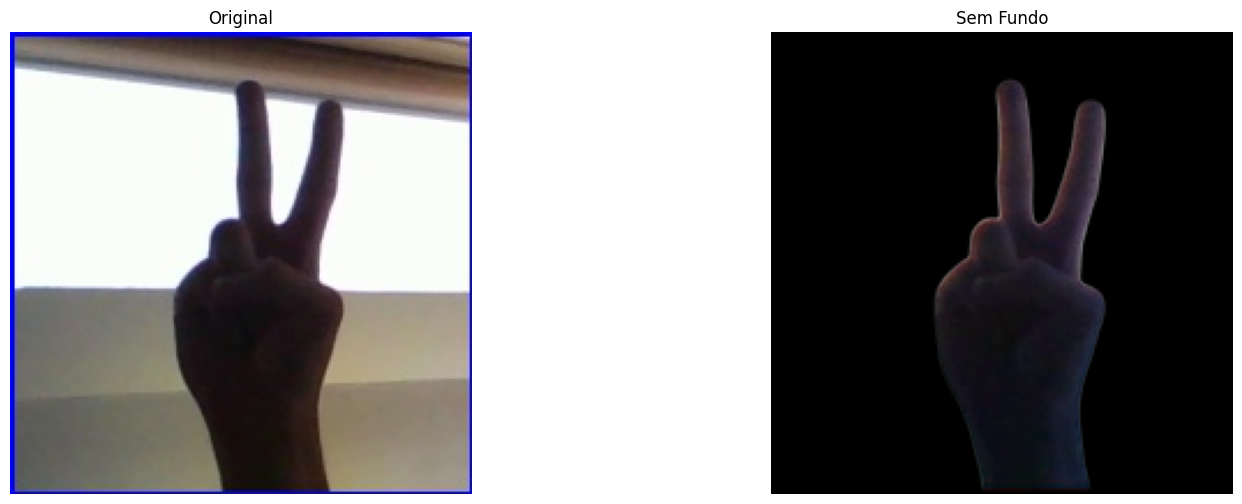

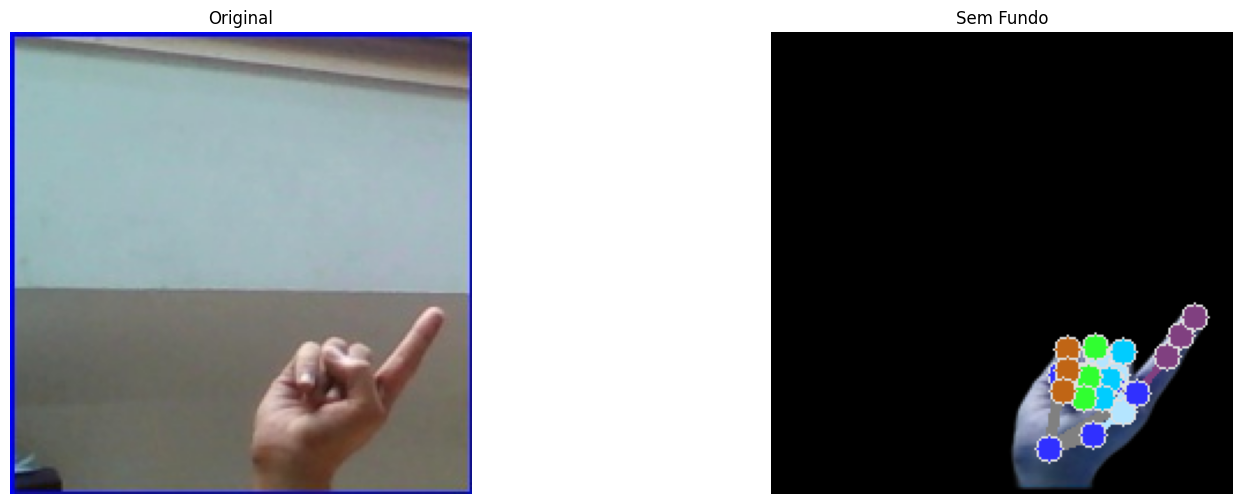

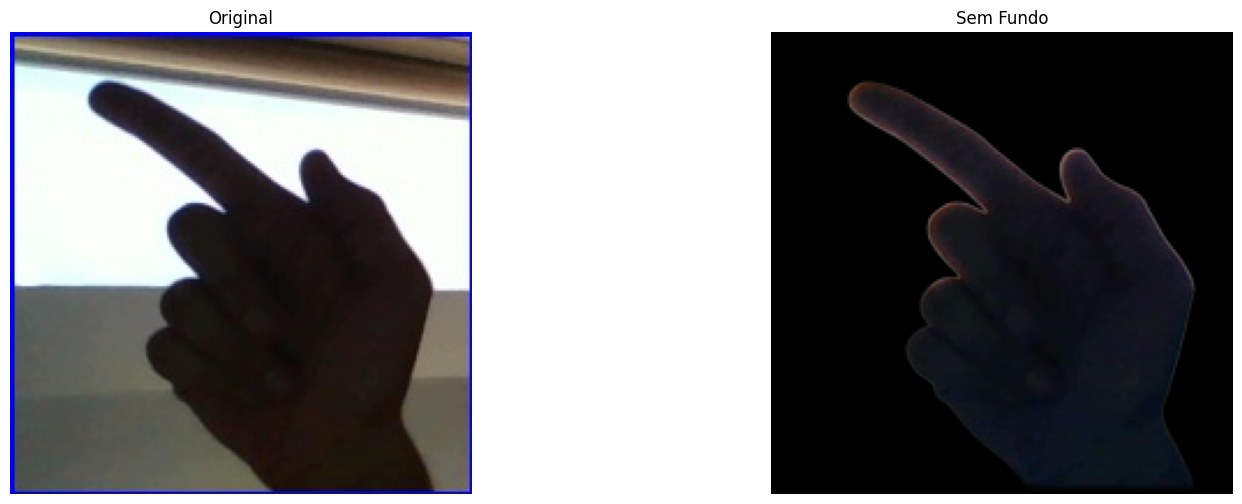

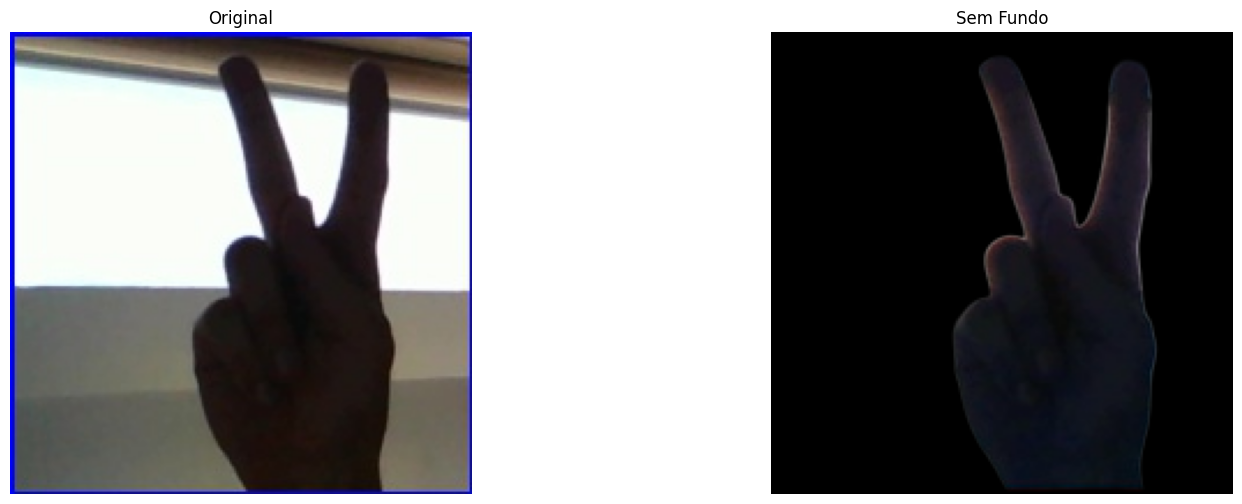

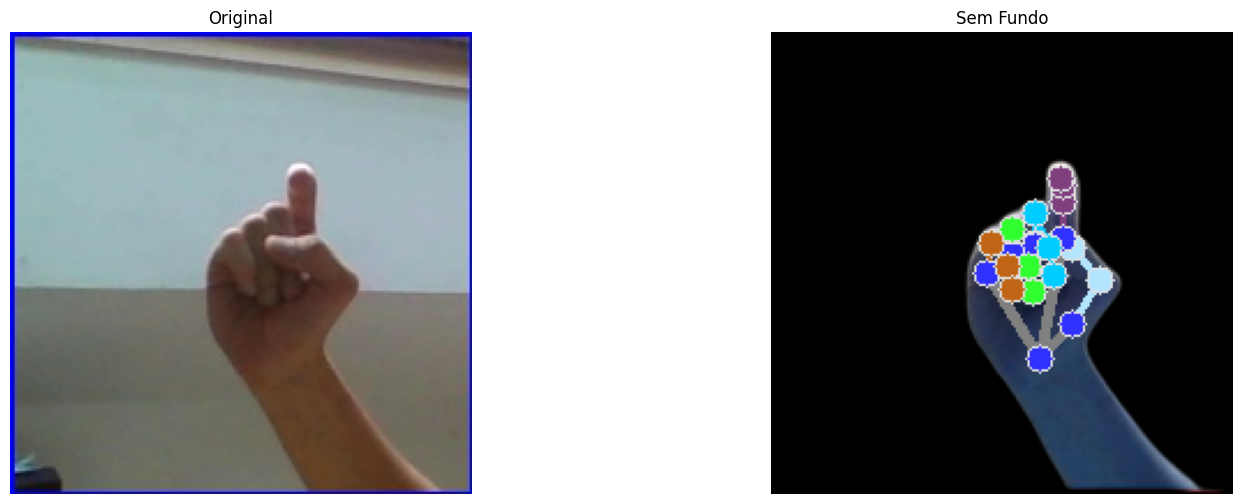

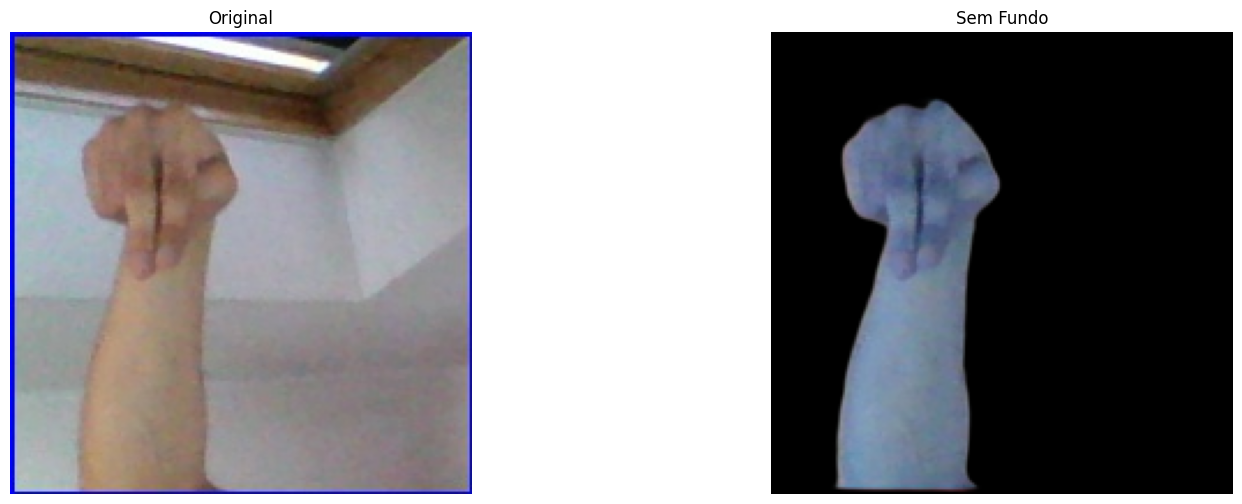

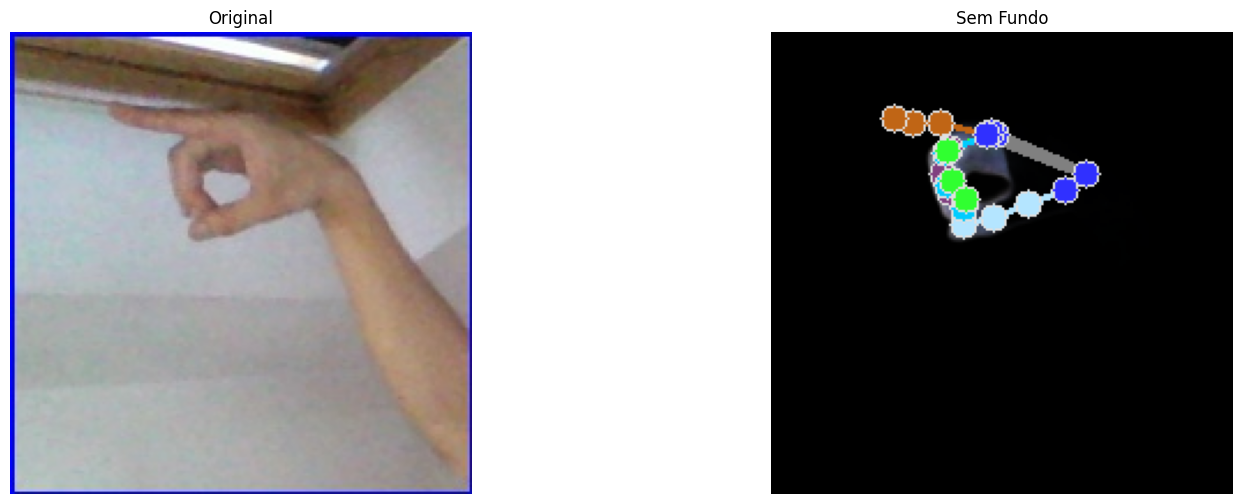

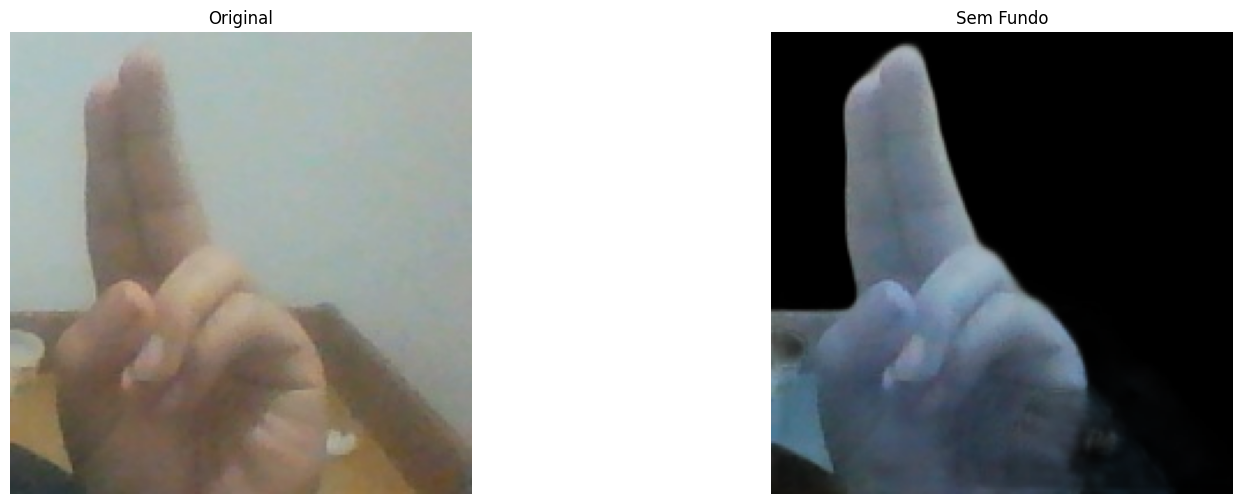

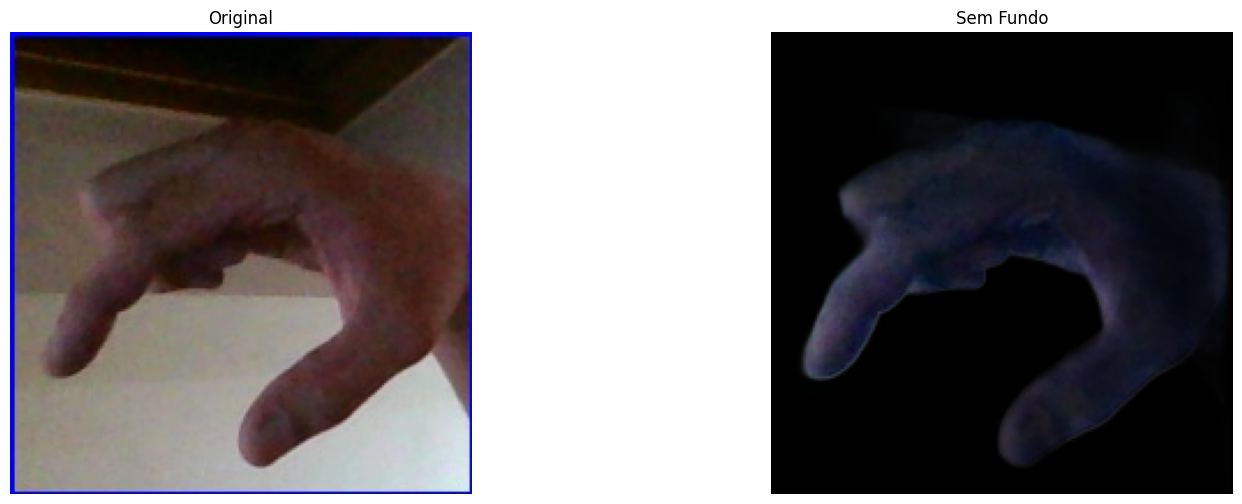

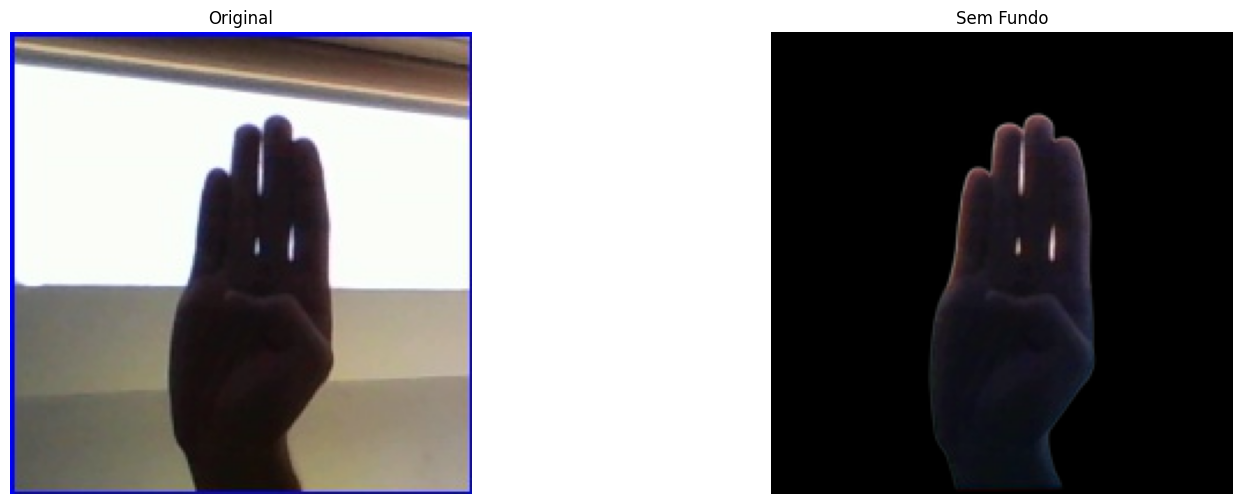

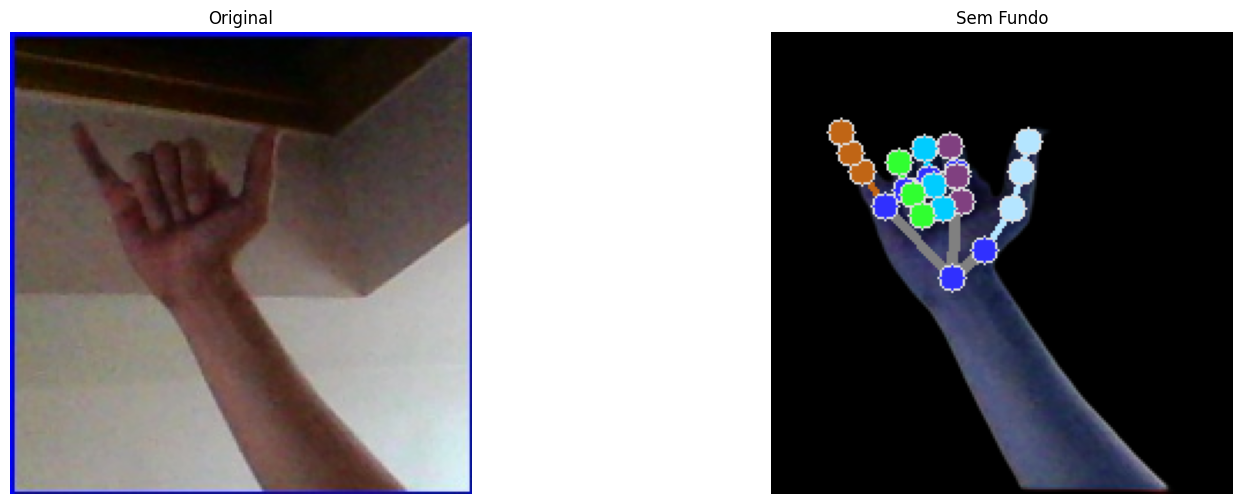

In [ ]:
mudanca_fundo_testes(path_ASL2, confidence)